In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import backend as K
tqdm.pandas()

In [2]:
df = pd.read_csv("tracks_similarity.csv")
df

,audio_track,target,estimated_similarity
0,tracks/17-Spirit Catcher--Secret Stranger (Dub...,tracks/17-Spirit Catcher--Secret Stranger (Dub...,5.0
1,tracks/05 - Shakedown - You Thing You Know.mp3,tracks/17-Spirit Catcher--Secret Stranger (Dub...,3.0
2,tracks/04 - House Is Mine (Baby Doc Remix).aif,tracks/17-Spirit Catcher--Secret Stranger (Dub...,0.0
3,tracks/010 - Casanovy - I Need Your Lovin' (Mi...,tracks/17-Spirit Catcher--Secret Stranger (Dub...,3.0
4,tracks/6 Transsylvanian Express.aiff,tracks/17-Spirit Catcher--Secret Stranger (Dub...,0.0
...,...,...,...
98,tracks/Bliss Inc - Subaquatic.mp3,tracks/17-Spirit Catcher--Secret Stranger (Dub...,2.0
99,tracks/11 Flux - Strange Feelings.aiff,tracks/17-Spirit Catcher--Secret Stranger (Dub...,0.0
100,tracks/10 - Little Computer People - Fly High.mp3,tracks/17-Spirit Catcher--Secret Stranger (Dub...,3.0
101,tracks/04. Giorgio Maulini - Storyteller (Orig...,tracks/17-Spirit Catcher--Secret Stranger (Dub...,3.0


In [3]:
def normalize_mel_spectrogram(mel_spectrogram):
    max_val = np.max(mel_spectrogram)
    min_val = np.min(mel_spectrogram)
    normalized_spectrogram = (mel_spectrogram - min_val) / (max_val - min_val)
    return normalized_spectrogram

def make_audio_extracts(audio, sample_duration, sample_rate, num_extracts):
    extract_size = sample_duration * sample_rate

    extracts = []
    for i in range(num_extracts):
        extracts.append(audio[extract_size * (i+1):extract_size * (i+2)])
    
    return extracts

def preprocess_data(csv_file_path, sample_duration=15, sample_rate=44100):
    df = pd.read_csv(csv_file_path)
    
    spectrograms = []
    labels = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        left_audio, _ = librosa.load(row['audio_track'], sr=sample_rate)
        right_audio, _ = librosa.load(row['target'], sr=sample_rate)

        left_audio_extracts = make_audio_extracts(left_audio, sample_duration, sample_rate, 1)
        sub_left_specs = []
        for extract in left_audio_extracts:
            left_spec = librosa.feature.melspectrogram(y=extract, sr=sample_rate)
            left_spec_db = librosa.power_to_db(S=left_spec, ref=np.max)
            left_spec_db = left_spec_db.T
            left_spec_db = normalize_mel_spectrogram(left_spec_db)

            sub_left_specs.append(left_spec_db)

        right_audio_extracts = make_audio_extracts(right_audio, sample_duration, sample_rate, 1)
        sub_right_specs = []
        for extract in right_audio_extracts:
            right_spec = librosa.feature.melspectrogram(y=extract, sr=sample_rate)
            right_spec_db = librosa.power_to_db(S=right_spec, ref=np.max)
            right_spec_db = right_spec_db.T
            right_spec_db = normalize_mel_spectrogram(right_spec_db)

            sub_right_specs.append(right_spec_db)

        for extract_left_spec, extract_right_spec in zip(sub_left_specs, sub_right_specs):
            spectrograms.append([extract_left_spec, extract_right_spec])
            labels.append(row['estimated_similarity'])
    
    return np.array(spectrograms), np.array(labels).astype(int)

In [4]:
csv_file_path = 'tracks_similarity.csv'
sample_rate = 22050

# Preprocess data
X, y = preprocess_data(csv_file_path, sample_duration=15, sample_rate=sample_rate)

  0%|          | 0/103 [00:00<?, ?it/s]

  3%|▎         | 3/103 [00:04<02:21,  1.41s/it]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!
Note: Illegal Audio-MPEG-Header 0x4c595249 at offset 17869602.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
 56%|█████▋    | 58/103 [01:03<00:49,  1.11s/it]Note: Illegal Audio-MPEG-Header 0x4c595249 at offset 14009914.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
100%|██████████| 103/103 [01:52<00:00,  1.09s/it]


In [5]:
def plot_spec_pair(left, right):
    fig, (ax1, ax2) = plt.subplots(2)
    img = librosa.display.specshow(left.T, x_axis='time',
                            y_axis='mel', sr=sample_rate,ax=ax1)

    ax1.set(title='Mel-frequency spectrogram, left track')

    img = librosa.display.specshow(right.T, x_axis='time',
                            y_axis='mel', sr=sample_rate,ax=ax2)

    ax2.set(title='Mel-frequency spectrogram right track')
    plt.tight_layout()
    plt.show()

Estimated similarity: 5


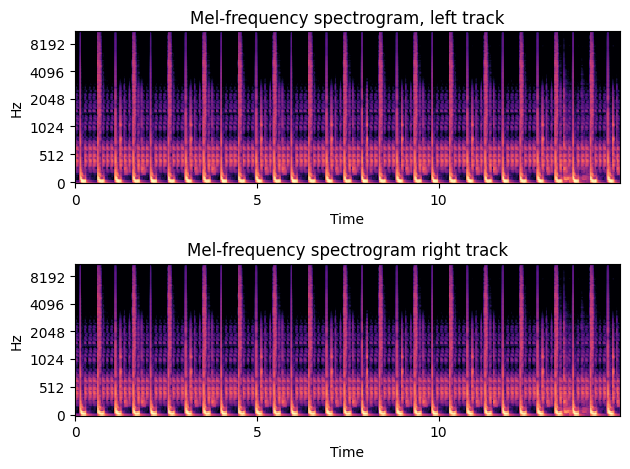

In [6]:
print(f"Estimated similarity: {y[0]}")
left, right = X[0]
plot_spec_pair(left, right)

Estimated similarity: 0


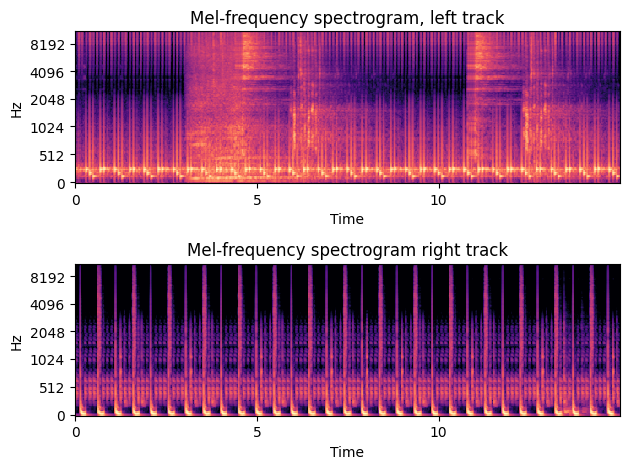

In [7]:
print(f"Estimated similarity: {y[2]}")
left, right = X[2]
plot_spec_pair(left, right)

## Load Model

In [8]:
def euclidean_distance(vecs):
    (left, right) = vecs
    ss = K.sum(K.square(left - right), axis = 1, keepdims=True)
    return K.sqrt(K.maximum(ss, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, _ = shapes
    return (shape1[0], 1)

def l2_pool_function(x):
    return tf.norm(x, axis=1)

def contrastive_loss(y_true, y_pred, margin=1):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

tf.keras.config.enable_unsafe_deserialization()
model = tf.keras.models.load_model(
    '../tracks_match/melspec_similarity_estimator.keras',
    custom_objects={
        'euclidean_distance': euclidean_distance,
        'eucl_dist_output_shape': eucl_dist_output_shape,
        'contrastive_loss': contrastive_loss,
        'l2_pool_function': l2_pool_function
        })

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 646, 128)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 646, 128)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 256)       │  8,787,200 │ input_layer[0][0… │
│ (Functional)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,361,602 (100.56 MB)

 Trainable params: 8,787,200 (33.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,574,402 (67.04 MB)

## Similarity prediction

In [9]:
prediction_dist = model.predict([X[:, 0], X[:, 1]]).ravel()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


In [10]:
df["prediction_dist"] = prediction_dist

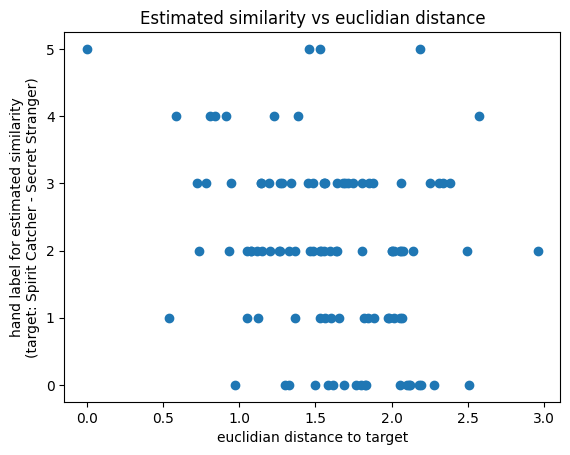

In [11]:
x = df["prediction_dist"]
y = df["estimated_similarity"]
plt.scatter(x, y)
plt.xlabel("euclidian distance to target")
plt.ylabel("hand label for estimated similarity\n(target: Spirit Catcher - Secret Stranger)")
plt.title("Estimated similarity vs euclidian distance")
plt.show()

In [81]:
df

,audio_track,target,estimated_similarity,prediction_dist
0,tracks/17-Spirit Catcher--Secret Stranger (Dub...,tracks/17-Spirit Catcher--Secret Stranger (Dub...,5.0,0.000316
1,tracks/05 - Shakedown - You Thing You Know.mp3,tracks/17-Spirit Catcher--Secret Stranger (Dub...,3.0,1.249318
2,tracks/04 - House Is Mine (Baby Doc Remix).aif,tracks/17-Spirit Catcher--Secret Stranger (Dub...,0.0,1.357912
3,tracks/010 - Casanovy - I Need Your Lovin' (Mi...,tracks/17-Spirit Catcher--Secret Stranger (Dub...,3.0,1.781260
4,tracks/6 Transsylvanian Express.aiff,tracks/17-Spirit Catcher--Secret Stranger (Dub...,0.0,2.117303
...,...,...,...,...
98,tracks/Bliss Inc - Subaquatic.mp3,tracks/17-Spirit Catcher--Secret Stranger (Dub...,2.0,1.641146
99,tracks/11 Flux - Strange Feelings.aiff,tracks/17-Spirit Catcher--Secret Stranger (Dub...,0.0,1.733243
100,tracks/10 - Little Computer People - Fly High.mp3,tracks/17-Spirit Catcher--Secret Stranger (Dub...,3.0,1.655631
101,tracks/04. Giorgio Maulini - Storyteller (Orig...,tracks/17-Spirit Catcher--Secret Stranger (Dub...,3.0,2.201666


In [80]:
df.sort_values(by='prediction_dist').head(10)

,audio_track,target,estimated_similarity,prediction_dist
0,tracks/17-Spirit Catcher--Secret Stranger (Dub...,tracks/17-Spirit Catcher--Secret Stranger (Dub...,5.0,0.000316
85,tracks/04. Witch Medicine.aiff,tracks/17-Spirit Catcher--Secret Stranger (Dub...,2.0,0.545730
39,tracks/06 - Subtech - Club Fodder (Original Mi...,tracks/17-Spirit Catcher--Secret Stranger (Dub...,2.0,0.738184
70,tracks/Felon5 - Moovin' (Floating Deep Mix).aiff,tracks/17-Spirit Catcher--Secret Stranger (Dub...,2.0,0.769907
97,tracks/14 - SDA - Vous êtes un arbre.mp3,tracks/17-Spirit Catcher--Secret Stranger (Dub...,1.0,0.864834
88,tracks/Maara - Fancy Feast - 03 Princess Expre...,tracks/17-Spirit Catcher--Secret Stranger (Dub...,2.0,0.869271
52,tracks/29. Basic Dawn - Pure Thrust (NU NRG Re...,tracks/17-Spirit Catcher--Secret Stranger (Dub...,0.0,0.879642
76,tracks/NeoFx - Banana Brain.mp3,tracks/17-Spirit Catcher--Secret Stranger (Dub...,0.0,0.920440
66,tracks/03 - Frozen (Meltdown Mix - Long Versio...,tracks/17-Spirit Catcher--Secret Stranger (Dub...,1.0,0.932334
30,tracks/B2 M.A.D. - Free (Friction & Spice's B...,tracks/17-Spirit Catcher--Secret Stranger (Dub...,3.0,0.957389
